# Data exploration

Your objective is to forecast the inventory levels for each product over the next 13 weeks, starting from the cutoff date of May 7, 2023.

1. **Introduction**
   - Schema
   - Setup
   - Data loading

2. **Columns inspection**
   - Formatting
   - NA values

3. **Categorical columns**
   - Distribution of sales and inventory by segment
   - Distribution of sales and inventory by prod_category

4. **Correlation**

5. **Length of the time series**

## 1. Introduction

### Schema

| Column Name       | Description                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| id                | An identifier for each time series, composed of yearweek + product_number. Example: 202301-1234567. |
| date              | The date in the format YYYY-MM-DD.                                                              |
| yearweek          | The year and week in the format YYYYWW.                                                         |
| product_number    | A unique identifier for each product.                                                           |
| reporterhq_id     | A unique identifier for each reseller (vendor).                                                 |
| prod_category     | The product category, which groups products from the same product line. (Often humorous names.) |
| specs             | Specifications of the product, such as RAM, graphics card, or other components.                 |
| segment           | The target segment of the product.                                                              |
| sales_units       | The number of units sold to the final customer for that week.                                   |
| **inventory_units**   | The target variable, representing the inventory for each product_number and reporterhq_id for a specific week. |


### Setup

In [91]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import utils.utils_plots as utils_plots
import utils.utils_preprocessing as utils_preprocessing

sns.set_theme(style="darkgrid")

### Data loading

In [21]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)
df_kaggle.tail()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
25134,202316-248724,2023-04-22,202316,248724,93,Arale,60921,17.3,Premium,0.0,69.0
25135,202317-248724,2023-04-29,202317,248724,15,Arale,60921,17.3,Premium,NaN,144.0
25136,202317-248724,2023-04-29,202317,248724,93,Arale,60921,17.3,Premium,2.0,130.0
25137,202318-248724,2023-05-06,202318,248724,15,Arale,60921,17.3,Premium,108.0,68.0
25138,202318-248724,2023-05-06,202318,248724,93,Arale,60921,17.3,Premium,23.0,95.0


## 2. Columns inspection
### Formatting

In [22]:
# Convert specified columns to desired types
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], format='%Y-%m-%d', errors='coerce')
df_kaggle['sales_units'] = pd.to_numeric(df_kaggle['sales_units'], errors='coerce')
df_kaggle['inventory_units'] = pd.to_numeric(df_kaggle['inventory_units'], errors='coerce')

# Create a new column 'sku' by concatenating 'reporterhq_id' and 'product_number'
df_kaggle['sku'] = df_kaggle['reporterhq_id'].astype(str) + "_" + df_kaggle['product_number'].astype(str)

In [23]:
# Column "spec" is useless: there is a 1:1 relationship between "spec" and "product_number" 
# we will drop it
is_unique_col1_to_col2 = df_kaggle.groupby('specs')['product_number'].nunique().max() == 1
is_unique_col2_to_col1 = df_kaggle.groupby('product_number')['specs'].nunique().max() == 1
assert is_unique_col1_to_col2 and is_unique_col2_to_col1

df_kaggle.drop(columns=['specs'], inplace=True)

In [24]:
categorical_columns = ['id', 'product_number', 'reporterhq_id', 'prod_category', 'display_size', 'segment', 'sku']
for col in categorical_columns:
    df_kaggle[col] = df_kaggle[col].astype('category')

df_kaggle = df_kaggle.sort_values(by='date')

In [25]:
df_kaggle.dtypes

id                       category
date               datetime64[ns]
year_week                   int64
product_number           category
reporterhq_id            category
prod_category            category
display_size             category
segment                  category
sales_units               float64
inventory_units           float64
sku                      category
dtype: object

### NA values

In [26]:
nan_counts = df_kaggle.isna().sum()
print(nan_counts)

id                   0
date                 0
year_week            0
product_number       0
reporterhq_id        0
prod_category        0
display_size         0
segment              0
sales_units        497
inventory_units    500
sku                  0
dtype: int64


### Categorical columns


- __product_number__ 233 distinct values
- __reporterhq_id__ 20 distinct values
- __prod_category__ 7 distinct values
- __display_size__ 9 distinct values
- __segment__ 3 distinct values
- __sku__ 506 distinct values

In [27]:
df_kaggle['segment'].value_counts()

segment
Core       12682
Premium     6242
Gaming      6215
Name: count, dtype: int64

In [28]:
df_kaggle['prod_category'].value_counts()

prod_category
Clover      7115
Goku        5424
Arale       4078
Doraemon    3455
Luffy       2044
Conan       2043
Bobobo       980
Name: count, dtype: int64

In [29]:
df_kaggle['display_size'].value_counts()

display_size
15.6    9793
17.3    4485
14.0    4417
13.3    3206
16.1    1926
13.5     876
11.0     292
11.6      97
12.0      47
Name: count, dtype: int64

- The same __reportehq_id__ is linked to multiple __product_number__
- Vice versa a __product_number__ is associated with multiple __reportehq_id__ 

Therefore the __id__ (yearweek_product_number. Unique identifier of the time series) contains duplicates.  
While modelling we will have 2 options:
- Directly forecast the time series identified by (sku = product_number + reporterhq_id). Then aggregate. (Bottom-Up)
- First aggregate at the product_number level and predict.

In [30]:
# Reporterhq_id vs num_distinct_products
df_num_distinct_products = pd.DataFrame(df_kaggle.groupby('reporterhq_id')['product_number'].nunique())
df_count_entries = pd.DataFrame(df_kaggle['reporterhq_id'].value_counts())
df_reporterhq = df_num_distinct_products.merge(
    df_count_entries, 
    left_index=True, 
    right_index=True
    ).sort_values('product_number', ascending=False).rename(columns={'product_number': 'num_distinct_products', 'count': 'num_entries'})

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_34688/186212025.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_num_distinct_products = pd.DataFrame(df_kaggle.groupby('reporterhq_id')['product_number'].nunique())


In [31]:
df_reporterhq

,num_distinct_products,num_entries
reporterhq_id,,
93,93,4212
15,92,3836
24,47,3893
3,45,3462
21,35,1563
12,29,1589
78,29,1988
90,28,1447
6,24,420


## 3. Categorical columns

### Distribution of sales and inventory by segment

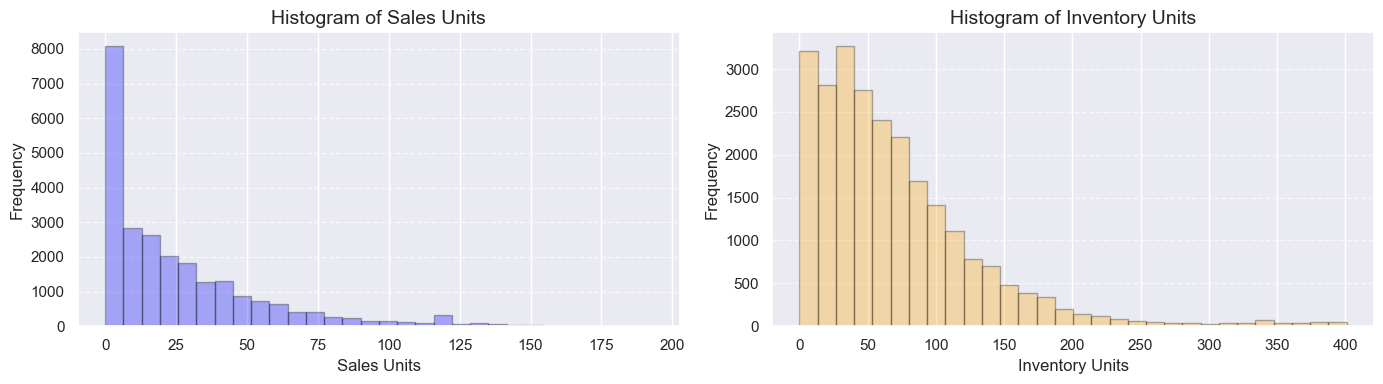

In [32]:
# Plot histograms for sales_units and inventory_units
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
df_kaggle['sales_units'].dropna().plot(kind='hist', bins=30, color='blue', edgecolor='black', alpha=0.3)
plt.title('Histogram of Sales Units', fontsize=14)
plt.xlabel('Sales Units', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
df_kaggle['inventory_units'].dropna().plot(kind='hist', bins=30, color='orange', edgecolor='black', alpha=0.3)
plt.title('Histogram of Inventory Units', fontsize=14)
plt.xlabel('Inventory Units', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/Users/matteogiaretti/Python/hp_use_case/utils/utils_plots.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (name, data) in zip(g.axes.flat, df.groupby(cat_col)):


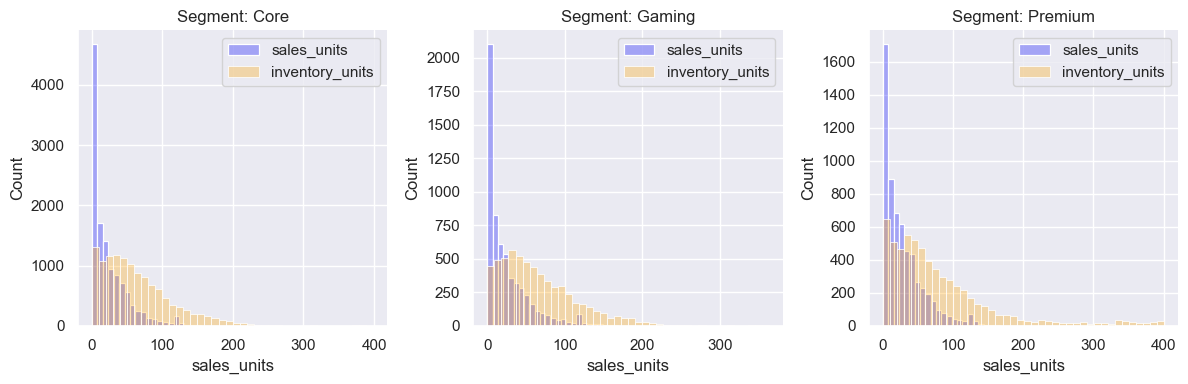

In [33]:
utils_plots.categorical_histogram(df=df_kaggle, cat_col="segment", log_scale=False)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_plots.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (name, data) in zip(g.axes.flat, df.groupby(cat_col)):


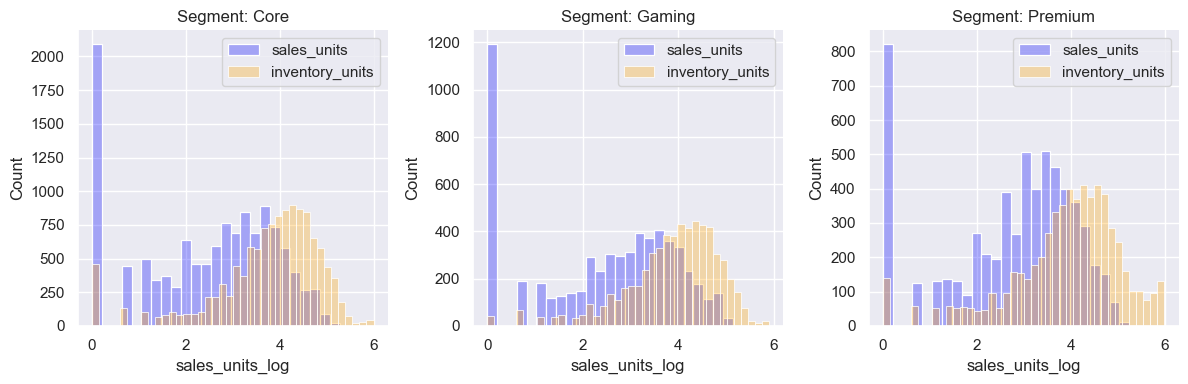

In [34]:
utils_plots.categorical_histogram(df=df_kaggle, cat_col="segment", log_scale=True)

<Axes: title={'center': 'Total Sales and Inventory Units per Day'}, xlabel='date'>

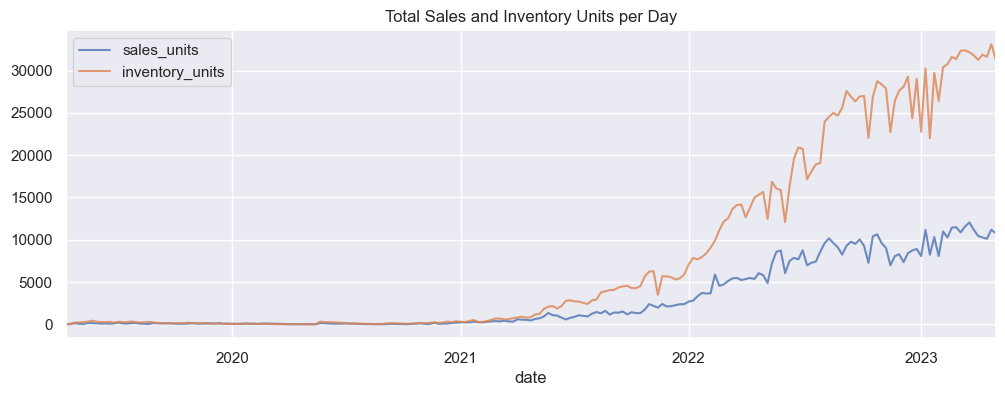

In [35]:
df_kaggle.groupby('date')[['sales_units', 'inventory_units']].sum().plot(
    figsize=(12, 4), title='Total Sales and Inventory Units per Day', alpha=0.8)

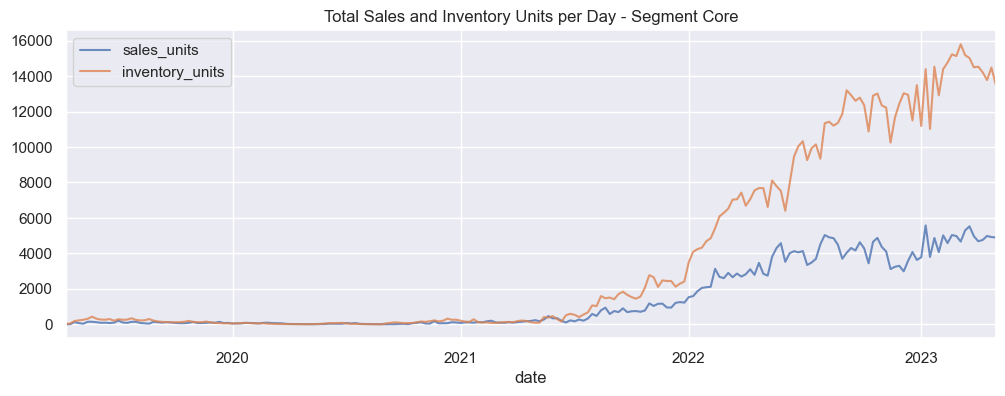

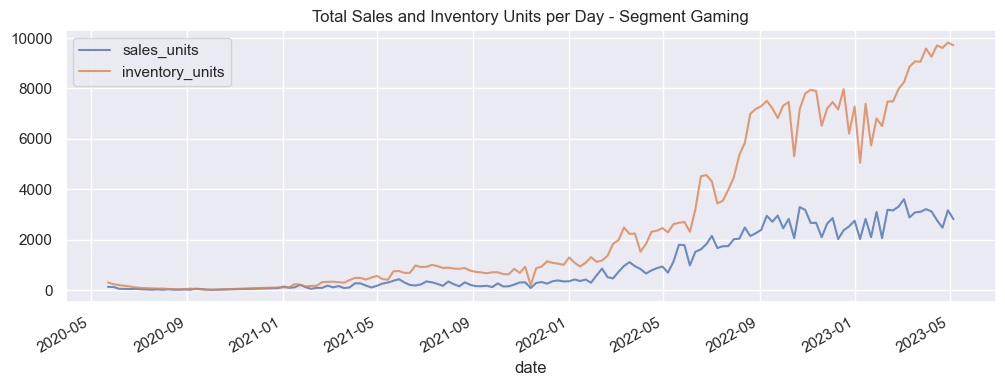

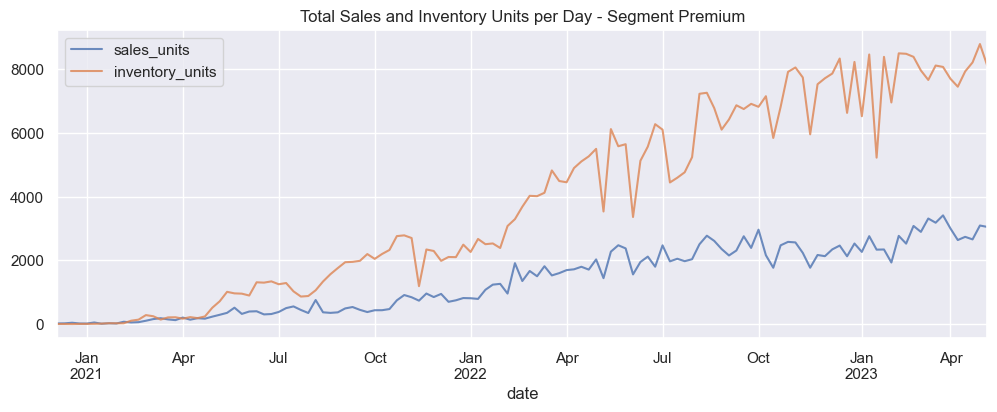

In [36]:
for segment in df_kaggle['segment'].unique():
    segment_data = df_kaggle[df_kaggle['segment'] == segment]
    segment_data.groupby('date')[['sales_units', 'inventory_units']].sum().plot(
        figsize=(12, 4), 
        title=f"Total Sales and Inventory Units per Day - Segment {segment}",
        alpha=0.8
    )

plt.show()

### Distribution of sales and inventory by prod_category

/Users/matteogiaretti/Python/hp_use_case/utils/utils_plots.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (name, data) in zip(g.axes.flat, df.groupby(cat_col)):


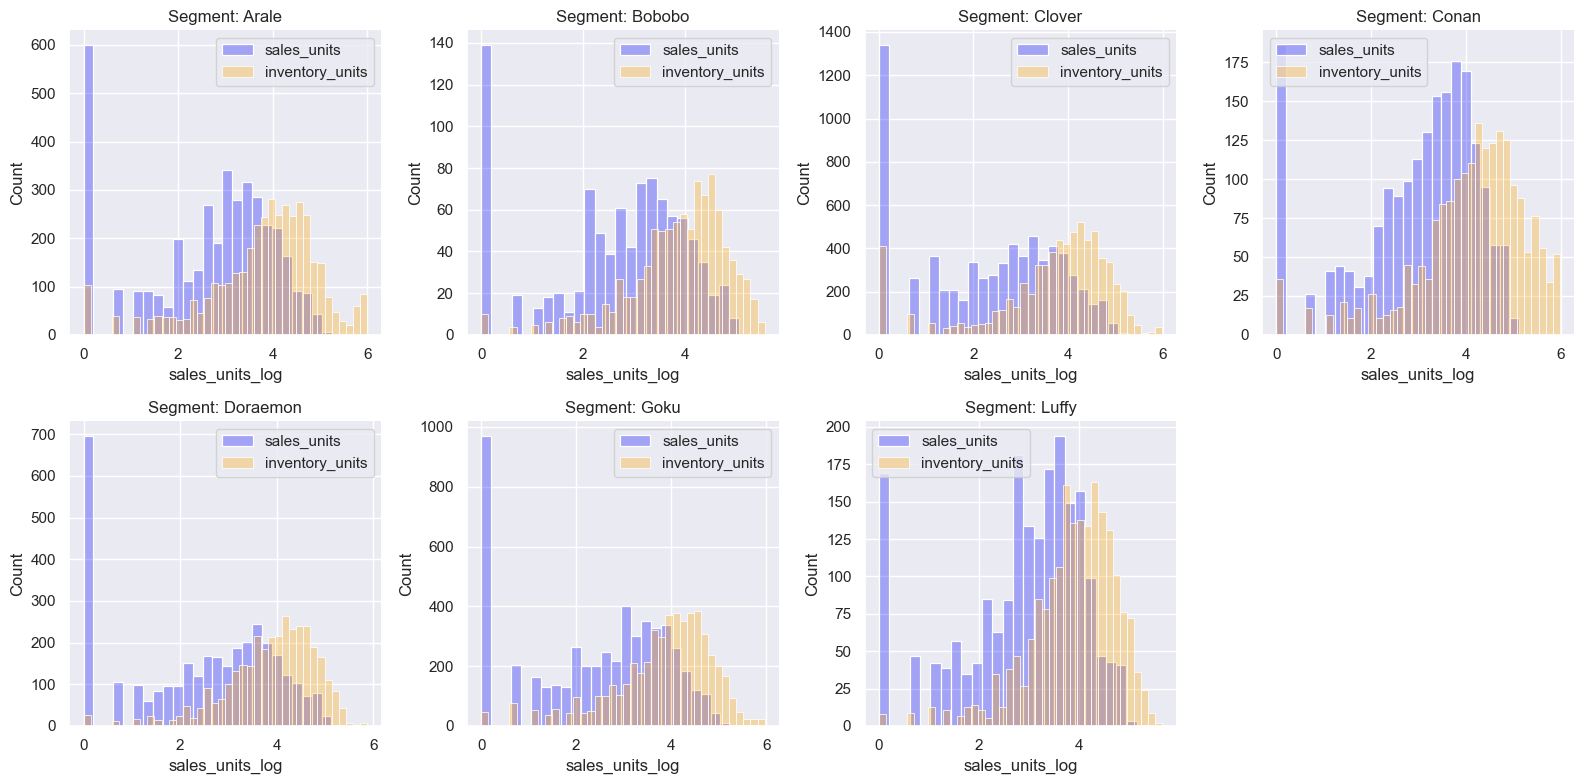

In [37]:
utils_plots.categorical_histogram(df=df_kaggle, cat_col="prod_category", log_scale=True)

## 4. Correlation

Correlation of sales_units and inventory_units

In [48]:
df = df_kaggle.groupby('date')[['sales_units', 'inventory_units']].sum()
df["sales_units"].corr(df["inventory_units"])

np.float64(0.9878540843553847)

In [49]:
correlation_list = []
for report_id in df_kaggle['reporterhq_id'].unique():
    df = df_kaggle.copy()
    df = df[df['reporterhq_id'] == report_id]
    df = df.groupby('date')[['sales_units', 'inventory_units']].sum()
    correlation = round(df["sales_units"].corr(df["inventory_units"]), 2)
    correlation_list.append((report_id, correlation))
    #print(f"Correlation for reporterhq_id {report_id}: {correlation}")

df_corr_by_reporterhq = pd.DataFrame(correlation_list, columns=['reporterhq_id', 'sales-inventory correlation']).set_index('reporterhq_id')

In [40]:
df_reporterhq.merge(df_corr_by_reporterhq, left_index=True, right_index=True)

,num_distinct_products,num_entries,sales-inventory correlation
reporterhq_id,,,
93,93,4212,0.87
15,92,3836,0.86
24,47,3893,0.91
3,45,3462,0.93
21,35,1563,0.86
12,29,1589,0.85
78,29,1988,0.91
90,28,1447,0.71
6,24,420,0.95


## 5. Length of the time series and missing values

Time series, both at the sku and at the product level can have very different history.

### Statistics and viz

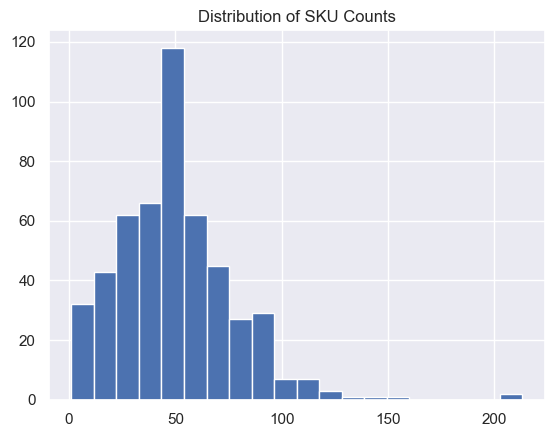

In [52]:
df_kaggle['sku'].value_counts().hist(bins=20)
plt.title("Distribution of SKU Counts")
plt.show()

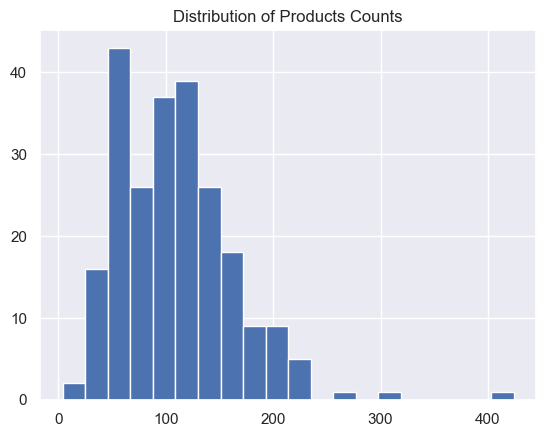

In [53]:
df_kaggle['product_number'].value_counts().hist(bins=20)
plt.title("Distribution of Products Counts")
plt.show()

In [67]:
df_agg = df_kaggle[['date', 'product_number', 'inventory_units', 'sales_units']].groupby(['date', 'product_number']).sum().reset_index().set_index('date')

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_34688/4262319638.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_kaggle[['date', 'product_number', 'inventory_units', 'sales_units']].groupby(['date', 'product_number']).sum().reset_index().set_index('date')


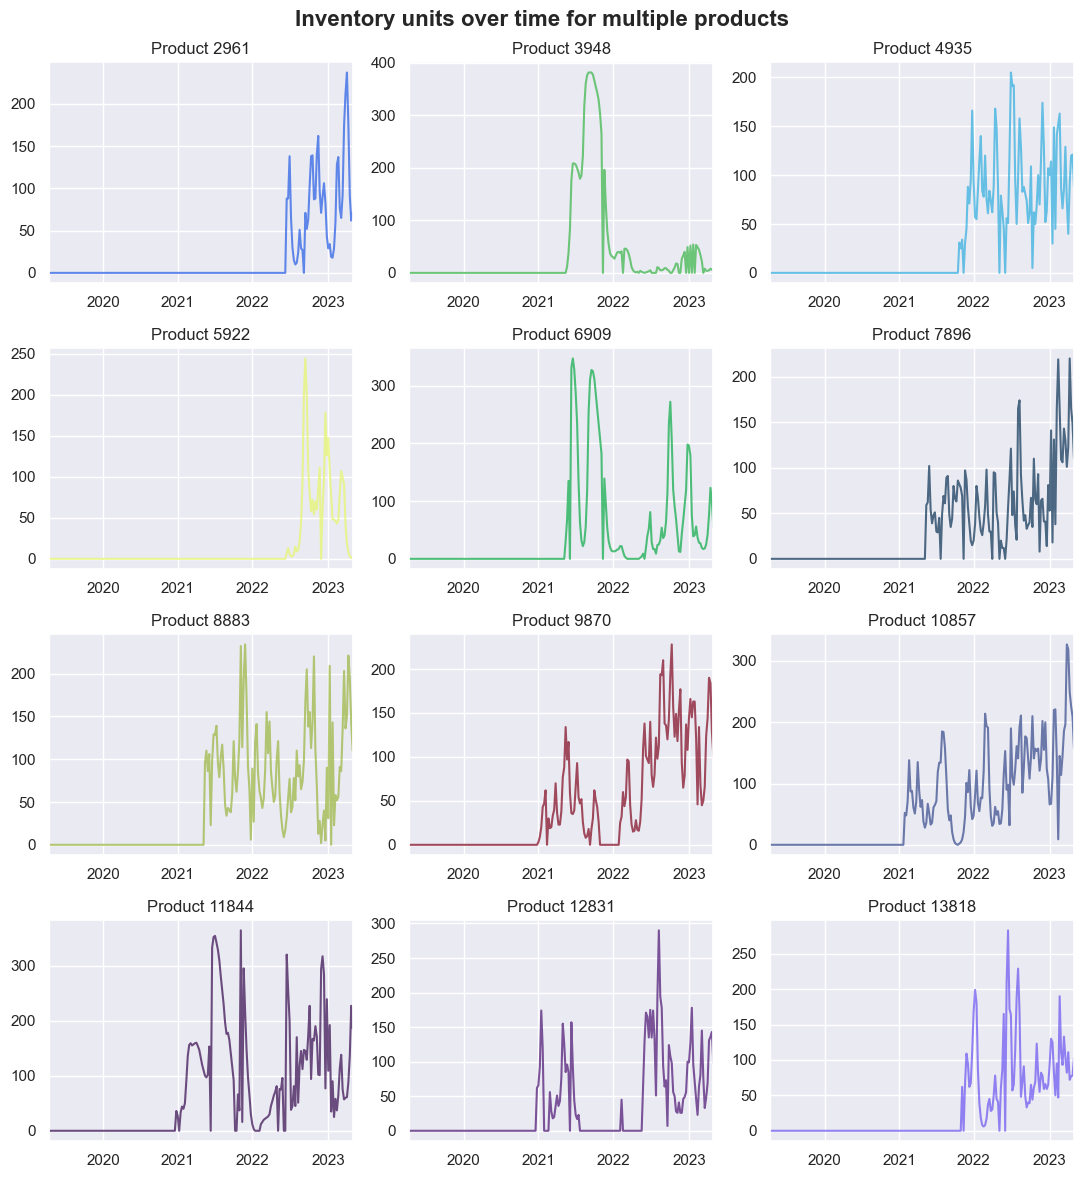

In [86]:
product_numbers = df_agg['product_number'].unique()[:12]  # Get up to 16 products

fig, axes = plt.subplots(4, 3, figsize=(11, 12))  
axes = axes.flatten()

for i, product in enumerate(product_numbers):
    ax = axes[i]
    df_agg[df_agg['product_number'] == product]['inventory_units'].plot(ax=ax, color=np.random.rand(3,), alpha=0.7)
    ax.set_title(f'Product {product}')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("Inventory units over time for multiple products", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

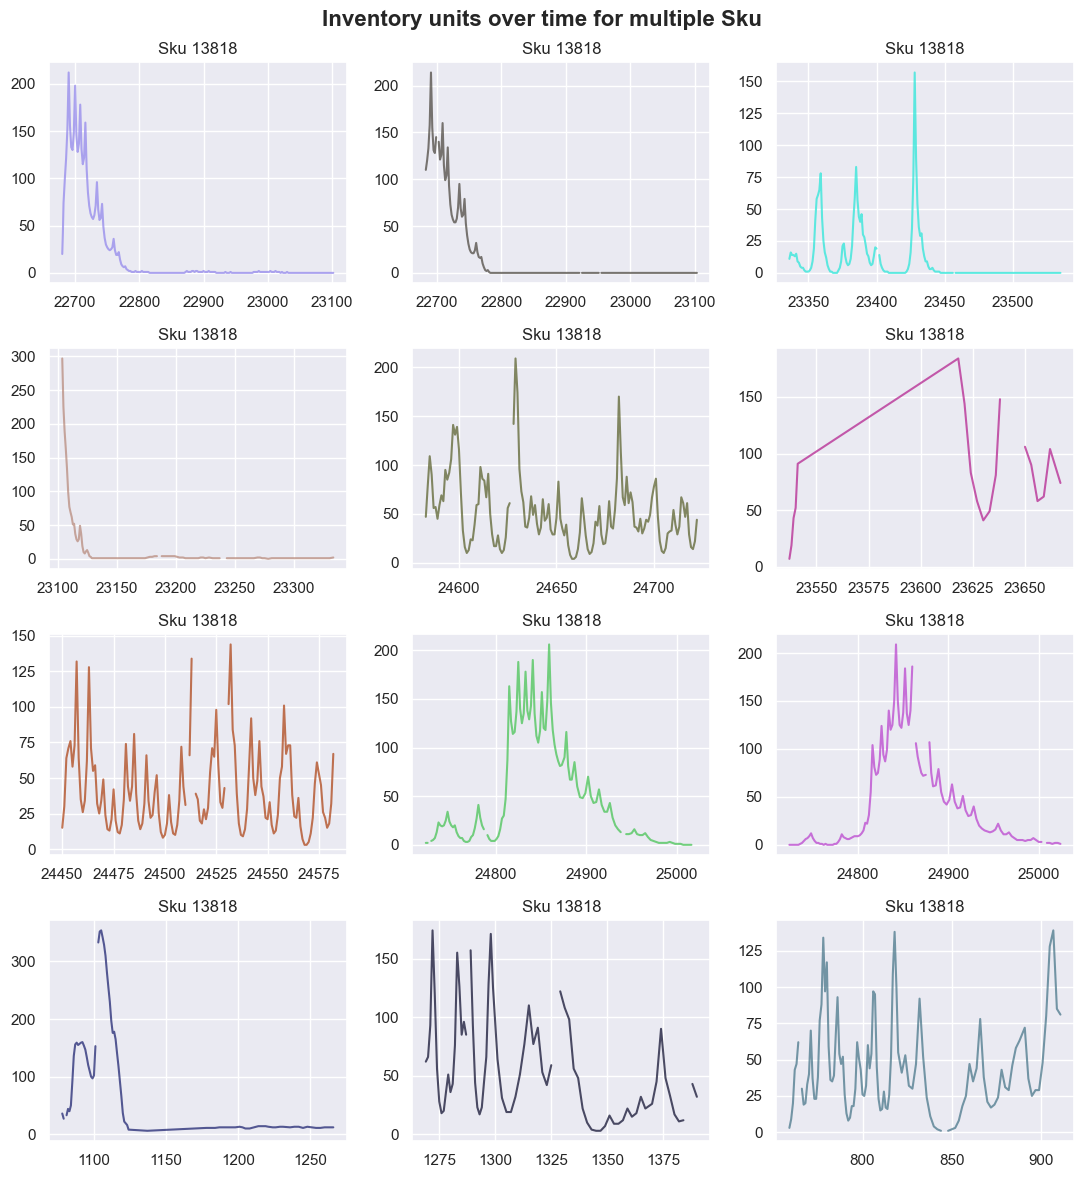

In [85]:
skus = df_kaggle['sku'].unique()[:12] 

fig, axes = plt.subplots(4, 3, figsize=(11, 12))  
axes = axes.flatten()

for i, sku in enumerate(skus):
    ax = axes[i] 
    df_kaggle[df_kaggle['sku'] == sku]['inventory_units'].plot(ax=ax, color=np.random.rand(3,), alpha=0.7)
    ax.set_title(f'Sku {product}')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("Inventory units over time for multiple Sku", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpolation


## Fill NA records

Fill NA's by using some time series method for each SKU in the data

In [24]:
# Find the sku with the highest number of NaN values in sales_units
nan_counts_sku = df_kaggle[df_kaggle['sales_units'].isna()] \
    .groupby('sku')['sales_units'] \
    .size()

sku_with_most_nans = nan_counts_sku.idxmax()
df_sku = df_kaggle[df_kaggle['sku'] == '78_45402'].reset_index()
nan_counts_sku.sort_values(ascending=False).head(5)

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/299985627.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sku')['sales_units'] \


sku
78_45402     6
24_81921     5
15_188517    5
93_55272     5
3_97713      4
Name: sales_units, dtype: int64

In [25]:
sku_with_most_nans

'78_45402'

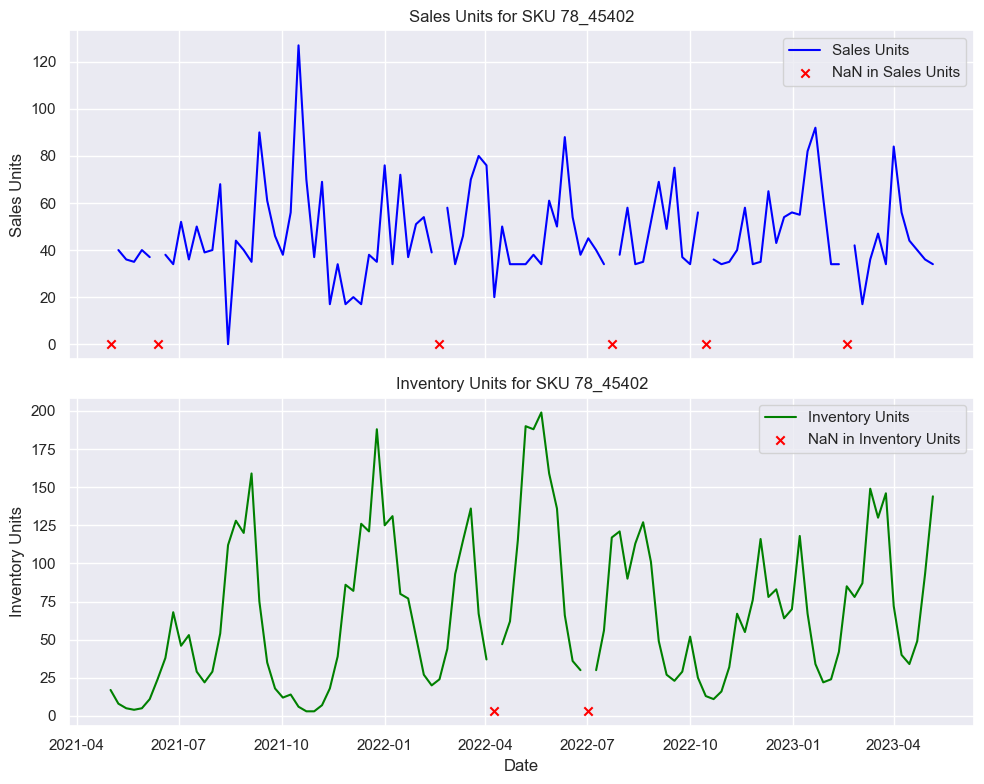

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot sales_units, highlighting NaN values
axes[0].plot(df_sku['date'], df_sku['sales_units'], color='blue', label='Sales Units')
axes[0].scatter(df_sku['date'][df_sku['sales_units'].isna()], 
                [df_sku['sales_units'].min()]*df_sku['sales_units'].isna().sum(),
                color='red', marker='x', label='NaN in Sales Units')
axes[0].set_title(f"Sales Units for SKU {sku_with_most_nans}")
axes[0].set_ylabel('Sales Units')
axes[0].legend()

# Plot inventory_units, highlighting NaN values
axes[1].plot(df_sku['date'], df_sku['inventory_units'], color='green', label='Inventory Units')
axes[1].scatter(df_sku['date'][df_sku['inventory_units'].isna()], 
                [df_sku['inventory_units'].min()]*df_sku['inventory_units'].isna().sum(),
                color='red', marker='x', label='NaN in Inventory Units')
axes[1].set_title(f"Inventory Units for SKU {sku_with_most_nans}")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Inventory Units')
axes[1].legend()

plt.tight_layout()
plt.show()

Fill the NaN values seen above:

In [27]:
# Interpolation and fill-in function
def interpolate_sku(group):
    # Sort by date and interpolate sales_units
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/1502501163.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/1502501163.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)


/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_25892/652638422.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_count = df_kaggle.groupby('sku')[['date']].count().sort_values(by='date', ascending=False)


array([[<Axes: title={'center': 'date'}>]], dtype=object)

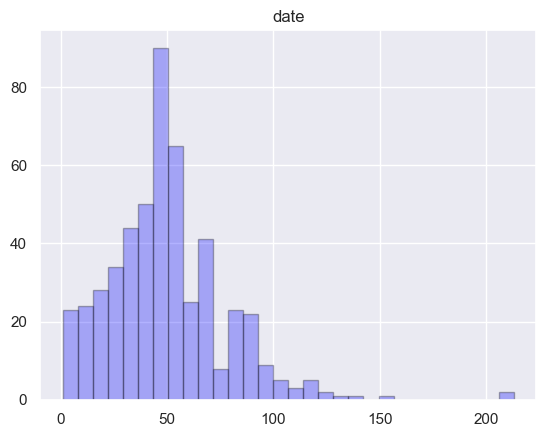

In [28]:
df_dates_count = df_kaggle.groupby('sku')[['date']].count().sort_values(by='date', ascending=False)
df_dates_count.hist(bins=30, color='blue', edgecolor='black', alpha=0.3)

In [29]:
df_dates_count['date'].describe()

count    506.000000
mean      49.681818
std       27.692933
min        1.000000
25%       32.000000
50%       47.000000
75%       64.000000
max      213.000000
Name: date, dtype: float64